In [2]:
import time
from PIL import Image
import numpy as np
from PIL import ImageFilter
from random import random

In [3]:
class node:
    def __init__(self, parent, rank=0, size=1):
        self.parent = parent
        self.size = size
        self.rank = rank

In [4]:
class grapth:
    def __init__(self, image_size):
        self.nodes = []
        self.edges = []
        
        self.min_size = 2200        
        self.image_size = image_size
        
    def add_nodes(self, num_nodes):
        for i in range(num_nodes):
            self.nodes.append(node(i))

    def node_size(self, node):
        return self.nodes[node].size

    def find_child(self, node):
        found = False
        current_node = node
        while not found:
            if(self.nodes[current_node].parent == current_node):
                found = True
                break
            current_node = self.nodes[current_node].parent
        self.nodes[node].parent = current_node            
        return current_node

    def get_parrent_child(self, x, y):
        if self.nodes[x].rank < self.nodes[y].rank:
            return x, y
        return y, x
    
    def merge(self, child_parrent):
        child, parrent = child_parrent
        self.nodes[parrent].parent = child
        self.nodes[child].size = self.node_size(child) + self.node_size(parrent)

        if self.nodes[child].rank == self.nodes[parrent].rank:
            self.nodes[parrent].rank += 1
    
    def node_id(self, x, y, width):
        return x + y * width
    
    def create_edge(self, width, img, x, y, x1, y1):
        self.edges.append((self.node_id(x, y, width), self.node_id(x1, y1, width), MSE(img, x, y, x1, y1)))

    def build_graph(self, img, size):
        width, height = size
        for y in range(height):
            for x in range(width):
                if 0 < x:
                    self.create_edge(width, img, x, y, x-1, y)
                if 0 < y:
                    self.create_edge(width, img, x, y, x, y-1)

                if 0 < x and 0 < y:
                    self.create_edge(width, img, x, y, x-1, y-1)

                if 0 < x and y < height-1:
                    self.create_edge(width, img, x, y, x-1, y+1)
        self.add_nodes(width * height)
        return self
    
    def smooth_grapth(self, sorted_edges):
        for edge in sorted_edges:
            node_a, node_b = self.find_child(edge[0]), self.find_child(edge[1])        
            if(node_a == node_b):
                continue
            if((self.node_size(node_a) < self.min_size or self.node_size(node_b) < self.min_size)):
                self.merge(self.get_parrent_child(node_a, node_b))
                
    def make_segment(self, constant):
        edge_weight = lambda edge: edge[2]

        sorted_graph = sorted(self.edges, key=edge_weight)
        threshold = []

        for index in range(len(self.nodes)):
            threshold.append((constant * 1.0 / 1))

        for edge in sorted_graph:
            node_a, node_b = self.find_child(edge[0]), self.find_child(edge[1])

            if node_a == node_b:
                continue

            if (edge_weight(edge) <= threshold[node_a]) and (edge_weight(edge) <= threshold[node_b]):
                self.merge(self.get_parrent_child(node_a, node_b))

                target = self.find_child(node_a)
                threshold[target] = edge_weight(edge) + (constant/self.nodes[target].size)
        self.smooth_grapth(sorted_graph)


In [5]:
def image_2_grapth(file_name):
    image = Image.open(open(file_name, "rb"))
    smooth_image = np.array(image.filter(ImageFilter.GaussianBlur(1)))
    return grapth(image.size).build_graph(smooth_image, smooth_image.shape[:2]), image

In [6]:
def MSE(image, x1, y1, x2, y2):
    return np.sqrt( np.sum( (image[y1, x1] - image[y2, x2]) ** 2 ) )

In [7]:
def generate_image(grapth):
    width, height = grapth.image_size
    
    random_color = lambda: [int(random() * 255), int(random() * 255), int(random() * 255)]
    colors = [ ]
    
    for i in range(width*height):
        colors.append(random_color())

    image = np.zeros((height, width, 3))
    for y in range(height):
        for x in range(width):
            index = grapth.find_child(y * width + x)
            image[y, x, :] = colors[index]
    return image

In [8]:
grapth_ref, input_image = image_2_grapth("lena512.bmp")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in ubyte_scalars
  


In [9]:
grapth_ref.make_segment(10)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

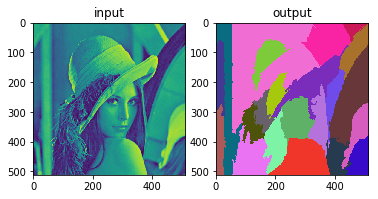

In [18]:
output_image = generate_image(grapth_ref)

figure, axes = plt.subplots(1,2)
axes[0].set_title("input")
axes[0].imshow(input_image)
axes[1].set_title("output")
axes[1].imshow(output_image)
